In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from datetime import datetime, date, time
# import time
from scipy import stats
import functions.carbon_utils as carbon_utilities
import PyCO2SYS as pyco2
from scipy import interpolate
from tabulate import tabulate
# import re
import matplotlib.gridspec as gridspec
# import functions.pH_NO3_DIC_pCO2_impact_calcs as derived_functions
import docx
import functions.float_data_processing as fl


In [2]:
# glodap_offsets_filename = 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4.nc'
# glodap_mean_offsets_filename = \
#     'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration.nc'

# glodap_offsets_filename = 'glodap_offsets_100km_1_to_50_50m_0.1dens_0.1spice_5.nc'
# glodap_mean_offsets_filename = glodap_offsets_filename[:-3] + '_floatmean_withcalibration.nc'

base_file_name = '100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_10'

# glodap_offsets_filename = 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_10_all_offsets_depth_grouped_year_filt_0_5_level_1500.nc'
# glodap_mean_offsets_filename = 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_10_floatmean_withcalibration_depth_grouped_year_filt_0_5_level_1500.nc'

glodap_offsets_filename = 'glodap_offsets_' + base_file_name + '_all_offsets_depth_grouped_year_filt_0_5_level_1500.nc'
glodap_mean_offsets_filename = 'glodap_offsets_' + base_file_name + '_floatmean_withcalibration_depth_grouped_year_filt_0_5_level_1500.nc'
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code

lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]
        
# Set the paths
# output_dir = 'output/'
# output_dir = 'output/glodap_offset_plots/grouped_plots/2024_01_02/'
output_dir =  argo_path + '../output_' + base_file_name + '/glodap_offset_plots/2024_01_16/'
data_dir = 'data/'
output_dir_figs = 'figures_o2_bias/'
manuscript_figs = '../figures/'
#check directories exist
if not os.path.isdir('figures_o2_bias'):
    os.mkdir('figures_o2_bias')

argo_path_derived = argo_path+'../derived_for_crossovers_' + base_file_name + '/'
argo_path_interpolated = argo_path + '../interpolated_for_crossovers_' + base_file_name + '/'
glodap_file_offsets_dir = argo_path + '../output_' + base_file_name + '/glodap_file_offsets_' + base_file_name + '/'



In [166]:
pH_alg = 'ESPER'

gdap = fl.get_glodap(data_dir, year = 2022)
gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
#set flagged data to NaN (is this needed? or masked array better?)
flagvars = ['G2salinity','G2oxygen','G2nitrate','G2tco2','G2talk','G2phts25p0', 'G2phtsinsitutp']

for v in flagvars:
    flag = v+'f'
    naninds = gdap[flag]!=2
    gdap[v][naninds] = np.nan

# GLODAP derived variables: density, MLD and pH

#calc potential density
gdap['sigma0_calculated'] = carbon_utilities.sigma0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)
#calculate spice
gdap['spice'] = carbon_utilities.spiciness0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)

#pH from LIPHR
# calculate LIPHR pH at Glodap points below 1480 m and above 2020m (V: where does the depth restriction come in?)
LIPHR_path = liar_dir
Coordinates = np.stack((gdap.G2longitude.values.flatten(), 
                        gdap.G2latitude.values.flatten(), 
                        gdap.G2pressure.values.flatten()),
                        axis=1)
Measurements = np.stack((gdap.G2salinity.values.flatten(), 
                         gdap.G2temperature.values.flatten(), 
                         gdap.G2oxygen.values.flatten()),
                         axis=1)

if pH_alg=='LIPHR':           
    MeasIDVec = [1, 7, 6]
    results = carbon_utilities.LIPHR_matlab(LIPHR_path,
                                        Coordinates.tolist(),
                                        Measurements.tolist(),
                                        MeasIDVec, 
                                        OAAdjustTF = False)            
elif pH_alg=='ESPER':
    MeasIDVec_ESPER = [1, 2, 6] # S, T, O2 - different numbering than v2 LIRs
    Equations = 7 # for ESPER - asking to use equation w/ S, T, and O2 only 
    DesiredVariables = [3] # in situ pH on total scale 

    # calculate decimal_year for ESPER
    da = gdap.datetime
    decimal_year = da.dt.year + (da.dt.dayofyear - 1 + (da.dt.hour * 3600 + da.dt.minute * 60 + da.dt.second) / 86400) / (365 + da.dt.is_leap_year)
    results = carbon_utilities.ESPER_mixed_matlab(LIPHR_path,
                                                    DesiredVariables,
                                                    Coordinates.tolist(),
                                                    Measurements.tolist(),
                                                    MeasIDVec_ESPER,
                                                    Equations, 
                                                    decimal_year.values.tolist(), 
                                                    0, 1)
gdap['pH_in_situ_total'] = results
gdap.pH_in_situ_total[np.isnan(gdap.G2phts25p0)] = np.nan
# gdap pH 25C 
gdap['pH_25C_TOTAL_ADJUSTED'] = carbon_utilities.co2sys_pH25C(2300.,gdap.pH_in_situ_total,gdap.G2temperature,
                                                         gdap.G2salinity,gdap.G2pressure)
#set pH to nan where there was no original pH data from GLODAP
gdap.pH_25C_TOTAL_ADJUSTED[np.isnan(gdap.G2phts25p0)]=np.nan

#rename GLODAP comparison variables to match argo
gdap = gdap.rename(columns={'G2longitude':'LONGITUDE', 'G2latitude':'LATITUDE', 'G2pressure':'PRES_ADJUSTED',
                            'G2temperature':'TEMP_ADJUSTED','G2salinity':'PSAL_ADJUSTED', 
                            'G2oxygen':'DOXY_ADJUSTED','G2nitrate':'NITRATE_ADJUSTED', 'G2tco2':'DIC', 
                            'G2talk':'TALK_LIAR', 'G2MLD':'MLD','G2o2sat':'o2sat', 'G2PTMP':'PTMP', 
                            'pH_in_situ_total':'PH_IN_SITU_TOTAL_ADJUSTED','sigma0_calculated':'PDENS'})

gdap['obs_index']=gdap.reset_index().index

https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0257247/GLODAPv2.2022_Merged_Master_File.csv


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/functions/float_data_processing.py:36: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdap = pd.read_csv(save_dir+'GLODAPv2.'+str(year)+'_Merged_Master_File.csv')
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_29864/2056779451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_29864/2056779451.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_29864/2056779451.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap.pH_in_situ_total[np.isnan(gdap.G2phts25p0)] = np.nan
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/equilibria/p1atm.py:419: RuntimeWarning: overflow encountered in power
  K1 = 10.0**-pK1  # this is on the NBS scale
/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/equilibria/p1atm.py:479: RuntimeWarning: overflow encountered in power
  K1 = 10.0**-pK1  # this is on the NBS scale


In [77]:
#load offset file
# os.listdir(glodap_file_offsets_dir)
offset_n = xr.load_dataset(glodap_file_offsets_dir+'5906522_glodap_offset.nc')
derived_n = xr.load_dataset(argo_path_derived + '5906522_derived.nc')

<xarray.DataArray 'JULD_LOCATION' (N_PROF: 1)>
array(['2022-05-31T16:15:10.001738240'], dtype='datetime64[ns]')
Dimensions without coordinates: N_PROF

In [91]:
offset_n

<xarray.Dataset>
Dimensions:                           (N_CROSSOVERS: 410)
Coordinates:
  * N_CROSSOVERS                      (N_CROSSOVERS) int64 0 1 2 ... 407 408 409
Data variables: (12/44)
    p_compare_min                     int64 1400
    p_compare_max                     int64 2100
    delta_dens                        float64 0.005
    delta_spice                       float64 0.005
    delta_press                       int64 100
    dist                              int64 100
    ...                                ...
    glodap_longitude                  (N_CROSSOVERS) float64 145.5 ... 139.0
    main_float_latitude               (N_CROSSOVERS) float64 29.94 ... 29.06
    glodap_latitude                   (N_CROSSOVERS) float64 30.0 30.0 ... 29.61
    glodap_cruise                     (N_CROSSOVERS) int64 272 459 ... 557 557
    glodap_station                    (N_CROSSOVERS) float64 34.0 ... 1.033e+03
    glodap_obs_index                  (N_CROSSOVERS) int64 420410 ... 829032

In [30]:
crossover_cruises = offset_n.glodap_cruise
crossover_stations = offset_n.glodap_station
print(crossover_cruises)
print(crossover_stations)

<xarray.DataArray 'glodap_cruise' (N_CROSSOVERS: 410)>
array([ 272,  459,  560,  563,  587,  588, 1035, 1035, 1081, 2028, 2032,
       2059, 2065, 2071, 2077, 2083, 4080,  272,  272,  272,  459,  459,
        560,  587,  588, 1081, 1087, 2059, 2065, 2069, 2071, 2077, 2083,
       4080,  272,  272,  272,  272,  272,  408,  436,  459,  587, 1035,
       1082,  560,  588,  589, 1056, 1082, 1082, 2059, 2071, 2081, 2081,
       2081, 2100, 4075, 4079, 4085,  560,  560,  589,  593, 1056, 1082,
       1082, 1082, 1082, 1087, 1091, 1092, 2032, 2050, 2058, 2059, 2059,
       2069, 2070, 2071, 2073, 2076, 2076, 2077, 2077, 2077, 2081, 2081,
       2081, 2083, 2088, 2090, 2090, 4075, 4079, 4080, 4085, 4090,  560,
        587,  593, 1056, 1082, 1082, 1082, 1092, 2032, 2057, 2058, 2059,
       2069, 2070, 2073, 2076, 2077, 2077, 2081, 2081, 2081, 2088, 2090,
       4079, 4090,  560,  560,  587,  589,  593, 1056, 1082, 1082, 1082,
       1088, 2032, 2057, 2058, 2059, 2069, 2073, 2076, 2077, 2077, 20

In [59]:
def find_closest_datetime(target_datetime, datetime_series):
    target_datetime = pd.Timestamp(target_datetime)
    return min(datetime_series, key=lambda dt: abs(target_datetime - dt))


In [102]:
gdap.G2phts25p0

0         -9999.0
1         -9999.0
2         -9999.0
3         -9999.0
4         -9999.0
            ...  
1381243   -9999.0
1381244   -9999.0
1381245   -9999.0
1381246   -9999.0
1381247   -9999.0
Name: G2phtsinsitutp, Length: 1381248, dtype: float64

In [117]:
# gdap_cruise = gdap[cruise_index]
# gdap.G2station[np.logical_and(cruise_index, ]
np.unique(gdap.G2cast[cruise_index])

array([1, 2, 3])

In [143]:

print(offset_n.glodap_cruise[i].values)
print(offset_n.glodap_station[i].values)

459
34.0


In [164]:
gdap_index = np.logical_and(gdap.G2cruise==offset_n.glodap_cruise[i].values , gdap.G2station==offset_n.glodap_station[i].values)

gdap.G2phts25p0[gdap_index]


717291      NaN
717292      NaN
717293    8.085
717294      NaN
717295      NaN
717296    7.998
717297    7.937
717298    7.850
717299      NaN
717300      NaN
717301    7.515
717302    7.393
717303    7.367
717304    7.385
717305    7.421
717306    7.433
717307    7.515
717308    7.551
717309    7.572
717310      NaN
717311    7.590
717312    7.597
717313    7.597
717314    7.593
Name: G2phts25p0, dtype: float64

In [156]:
idx = gdap.G2station==offset_n.glodap_station[i].values
print(var)
gdap_cruise['PH_IN_SITU_TOTAL_ADJUSTED'][idx]

pH_25C_TOTAL_ADJUSTED


420389   NaN
420390   NaN
420391   NaN
420392   NaN
420393   NaN
420394   NaN
420395   NaN
420396   NaN
420397   NaN
420398   NaN
420399   NaN
420400   NaN
420401   NaN
420402   NaN
420403   NaN
420404   NaN
420405   NaN
420406   NaN
420407   NaN
420408   NaN
420409   NaN
420410   NaN
420411   NaN
420412   NaN
420413   NaN
420414   NaN
420415   NaN
420416   NaN
420417   NaN
420418   NaN
420419   NaN
420420   NaN
420421   NaN
420422   NaN
420423   NaN
420424   NaN
Name: PH_IN_SITU_TOTAL_ADJUSTED, dtype: float64

[24.65,
 24.657,
 24.65788,
 24.658,
 24.659,
 24.657179,
 24.657,
 24.656,
 24.657,
 24.656694,
 24.656,
 24.651,
 24.60823,
 24.604,
 24.471,
 24.267,
 24.202,
 24.111,
 23.685,
 23.526,
 23.520544,
 23.376,
 23.218,
 23.15716,
 23.062,
 22.645,
 22.305952,
 22.289,
 22.011,
 21.718,
 21.677525,
 21.548,
 21.446,
 21.228449,
 21.217,
 21.034,
 20.979,
 20.94105,
 20.869,
 20.727,
 20.61397,
 20.6,
 20.45,
 20.284,
 20.23912,
 20.182,
 20.127,
 20.169369,
 20.177,
 20.171,
 20.0,
 19.95632,
 19.888,
 19.768,
 19.69672,
 19.687,
 19.607,
 19.495,
 19.4338,
 19.351,
 19.195,
 19.16712,
 19.154,
 19.102,
 19.067,
 19.05468,
 19.039,
 18.991,
 18.968319,
 18.963,
 18.955,
 18.914,
 18.83,
 18.684,
 18.643724,
 18.639,
 18.611,
 18.525,
 18.487,
 18.487,
 18.4806,
 18.479,
 18.354,
 18.242,
 18.18,
 18.153,
 18.14266,
 18.142,
 18.135,
 18.129,
 18.121,
 18.103,
 18.060934,
 18.056,
 18.025,
 18.019,
 18.005,
 17.965,
 17.948105,
 17.934,
 17.917,
 17.903,
 17.872,
 17.855,
 17.843103,
 17

1


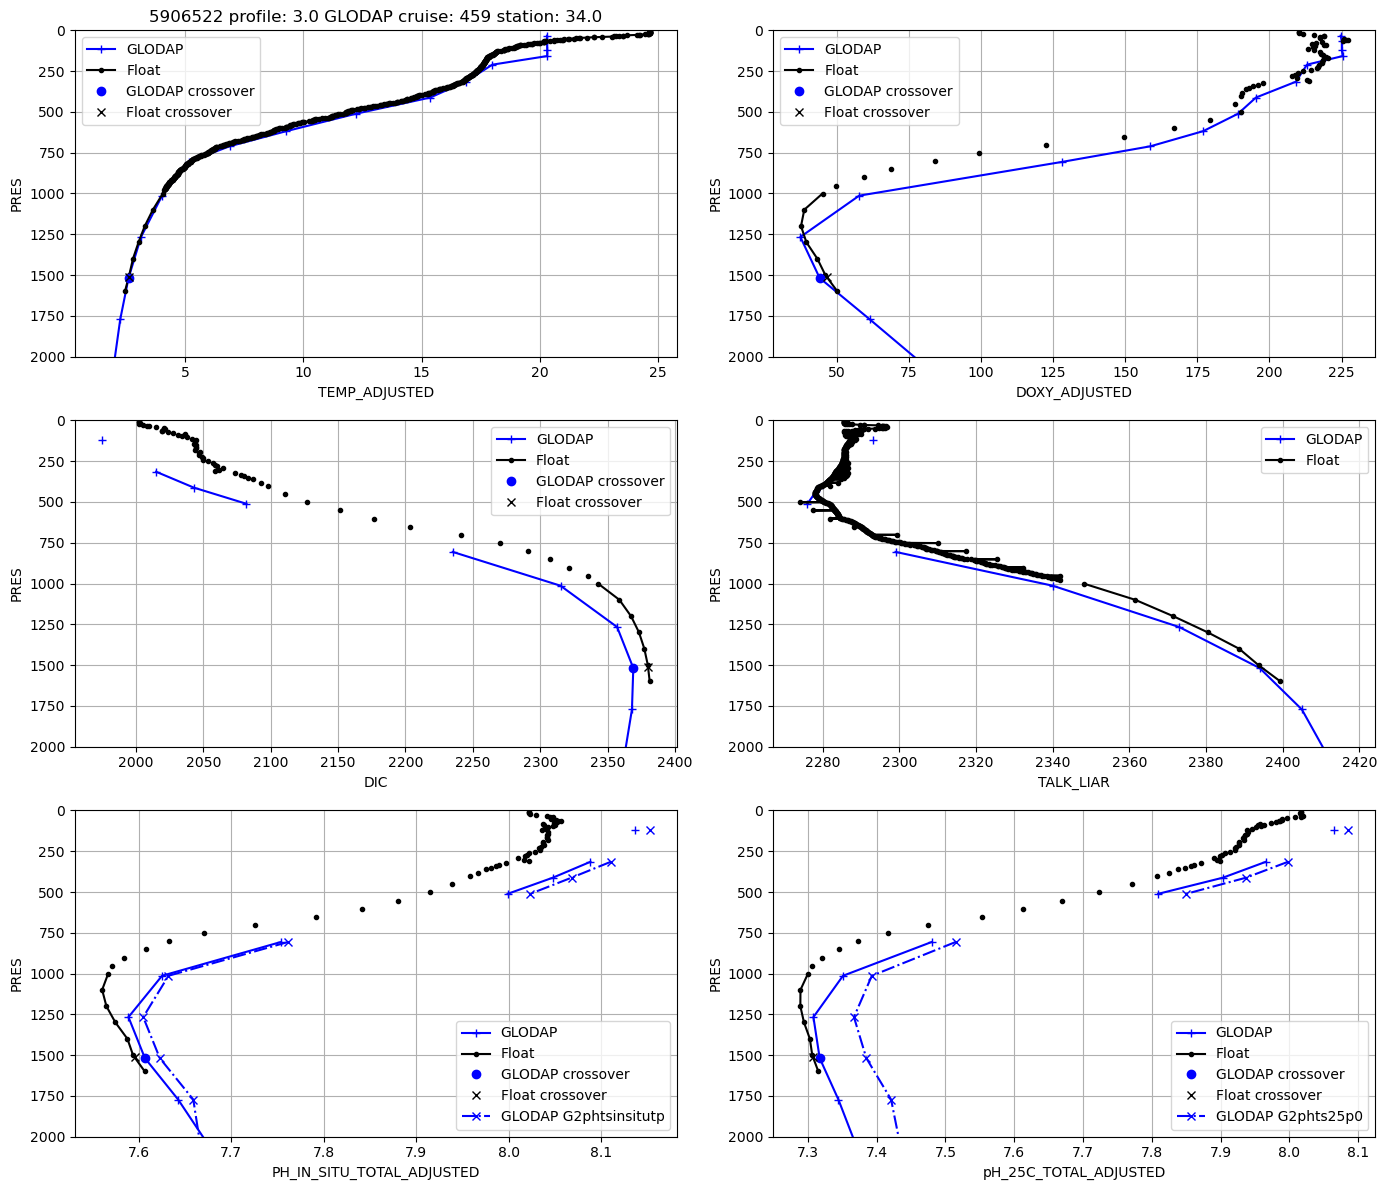

Exiting the loop.


In [189]:
var_list = ['TEMP_ADJUSTED', 'DOXY_ADJUSTED', 'DIC', 'TALK_LIAR', 'PH_IN_SITU_TOTAL_ADJUSTED', 'pH_25C_TOTAL_ADJUSTED']

cruise_index = gdap.G2cruise==crossover_cruises[0].item()
gdap_cruise = gdap[cruise_index]

for i in range(1, len(offset_n.DOXY_ADJUSTED_offset)):
    print(str(i))
    plt.figure(figsize=(14,12))

    if np.isnan(offset_n['PH_IN_SITU_TOTAL_ADJUSTED_offset'][i]):
        continue

    # find index of matching profile in the derived file
    prof_n = offset_n.main_float_profile[i].values
    prof_idx = derived_n.CYCLE_NUMBER==prof_n
    # derived_n.JULD_LOCATION[prof_idx]

    # find matching glodap datetime
    # closest_datetime = find_closest_datetime(offset_n['glodap_datetime'][i].item(), gdap_cruise.datetime)
    # gdap_index = np.logical_and(gdap.G2cruise==offset_n.glodap_cruise[i].values , gdap.G2station==34)

    # idx = np.logical_and(gdap.G2cruise==offset_n.glodap_cruise[i].values , gdap.G2station==offset_n.glodap_station[i].values)
    # idx = gdap.G2station==offset_n.glodap_station[i].values

    gdap_index = np.logical_and(gdap.G2cruise==offset_n.glodap_cruise[i].values , gdap.G2station==offset_n.glodap_station[i].values)

    for d, var in enumerate(var_list):
        plt.subplot(3,2,d+1)

        if d==0:
            plt.title(str(offset_n.main_float_wmo[0].values) + ' profile: ' +str(prof_n) + ' GLODAP cruise: ' + str(offset_n.glodap_cruise[i].values) + ' station: ' + str(offset_n.glodap_station[i].values))
        # idx = gdap_cruise.datetime==closest_datetime
        # offset_n['glodap_datetime'][0]
        # # for idx, cruise in enumerate(crossover_cruises):
        # #     station_index = np.logical_and(gdap.G2station==crossover_stations[idx].item(), gdap.datetime==offset_n['glodap_datetime'][0])

        # plt.plot(gdap_cruise[var][idx], gdap_cruise.PRES_ADJUSTED[idx], 'b+', label='GLODAP')
        plt.plot(gdap[var][gdap_index], gdap.PRES_ADJUSTED[gdap_index], 'b+-', label='GLODAP')

        plt.plot(derived_n[var][prof_idx,:].values.T, derived_n.PRES_ADJUSTED[prof_idx,:].values.T, 'k.-', label='Float')


        if var != 'TALK_LIAR':
            plt.plot(offset_n[var + '_glodap'][i], offset_n.PRES_ADJUSTED_glodap[i], 'bo', label='GLODAP crossover')
            plt.plot(offset_n[var + '_float'][i], offset_n.PRES_ADJUSTED_float[i], 'kx', label='Float crossover')

        if var == 'PH_IN_SITU_TOTAL_ADJUSTED':
            plt.plot(gdap['G2phtsinsitutp'][gdap_index], gdap.PRES_ADJUSTED[gdap_index], 'bx-.', label='GLODAP G2phtsinsitutp')
        
        if var == 'pH_25C_TOTAL_ADJUSTED':
            plt.plot(gdap['G2phts25p0'][gdap_index], gdap.PRES_ADJUSTED[gdap_index], 'bx-.', label='GLODAP G2phts25p0')

        plt.ylim([2000, 0])
        plt.xlabel(var)
        plt.ylabel('PRES')
        plt.legend()
        plt.grid('on')

    plt.tight_layout()
    plt.show()
    user_input = input("Press Enter to continue or 'q' to quit: ")
    
    # Check if the user wants to quit
    if user_input.lower() == 'q':
        print("Exiting the loop.")
        break    